# Modelo predictivo para la producción cafetera

Este proyecto tiene como objetivo implementar una herramienta automatizada para predecir la cosecha de café en un intervalo de fechas dado a partir de imágenes de cafetos mediante técnicas de aprendizaje profundo. La necesidad surge en el contexto de la industria cafetera, donde una predicción precisa de las cosechas futuras es crucial para la planificación de la cosecha, la logística y la negociación de contratos de exportación, que son en su mayoria de venta a futuro.

El modelo desarrollado apunta reemplazar métodos tradicionales de muestreo manual, que resultan costosas y tediosas, por un sistema que analiza imágenes y predice cuantos kilos de café se podrán cosechar en un intervalo de fechas dado.


## Dependencias

Si esta corriendo este notebook desde Colab, **no se debe preocupar por instalar dependencias**, las celdas de abajo lo haran automaticamente.  
</br>
Si no usa Colab, puede clonar el repositorio e instalar las dependencias: `pip install requirements.txt`.

In [1]:
import sys

if "google.colab" in sys.modules:
    !git clone --depth 1 https://github.com/JuanJoZP/coffee-production-dl.git
    !mv coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/data .
    !mv coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/requirements.txt .
    !pip install -r requirements.txt
    !rm -rf coffee-production-dl
    !rm /content/requirements.txt

else:
    DATA_PATH = "../data"
    RUNS_PATH = "./runs"

Cloning into 'coffee-production-dl'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 57 (delta 0), reused 51 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 245.49 MiB | 29.31 MiB/s, done.
Updating files: 100% (47/47), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 765.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

## Arquitectura de la solución

La solución propuesta se compone de una serie de modelos encadenados, cada uno encargado de una etapa específica del proceso de predicción. La arquitectura está diseñada en múltiples fases para maximizar la precisión y reducir el ruido en cada etapa:

1. Detección de Clústeres de Granos (Modelo detección)

   Se utiliza un modelo supervisado de detección de objetos, para localizar los clústeres o agrupaciones de granos de café en las ramas de los cafetos. Este modelo se reentrena con imágenes específicas de cafetos, generando bounding boxes sobre las agrupaciones visibles. Esta primera etapa permite identificar regiones candidatas para análisis más detallado.

2. Detección de Granos Individuales (Modelo detección)

    Las imágenes recortadas de los clústeres detectados en la etapa anterior se procesan con un segundo modelo de detección de objetos, también supervisado, entrenado para detectar granos individuales. Este enfoque en dos pasos permite reducir el ruido visual del entorno (hojas, ramas, fondo) y estandariza el tamaño de los granos dentro de una imagen más limpia y acotada. Así se mejora la precisión de detección de los granos, incluso en distintos estados de maduración o tamaños.

3. (Opcional) Eliminación del ruido (Modelo segmentación)

   Cada imagen de grano pasa por un modelo de segmentación no supervisado, cuya función es separar los píxeles pertenecientes al grano de aquellos que representan ruido o fondo. Este paso clasifica cada píxel en dos clases (grano vs. no grano) y puede ser útil para mejorar la precisión del modelo de regresión posterior.

4. Estimación del Tiempo de Maduración (Modelo regresión)

   Una vez aislado cada grano, se utiliza un modelo de regresión supervisado que estima cuántos días faltan para que ese grano esté listo para cosecha. El modelo puede usar como entrada la imagen segmentada del grano o descriptores derivados de ella, y fue entrenado con ejemplos etiquetados manualmente, basado en conocimiento y experiencia directa con el cultivo del café.

5. Cálculo de Producción en un Intervalo de Fechas

   Finalmente, el sistema permite al usuario definir un intervalo de fechas de interés. El sistema filtra los granos que estarán listos para cosecha dentro de ese intervalo, estima el número total de granos cosechables, y multiplica este número por un peso promedio por grano para obtener una predicción final en kilos. Además, se podría generar automáticamente un reporte temporal, por ejemplo con la producción proyectada cada dos semanas, facilitando la planificación logística, de mano de obra y de contratos de exportación.

## Implementación

### 1. Detección Clusteres

Se etiquetaron manualmente los clusters de granos para las 20 fotos que componen nuestro dataset, se hizo uso del software Labelme.  

Una imagen etiquetada se ve así:

![img1.png](https://raw.githubusercontent.com/JuanJoZP/coffee-production-dl/67835c31929d3b8e43dda8b0ab66c82f4e01ec86/ProduccionCafe_JuanPacheco_JuanZuluaga/src/notebook_imgs/img1.png)

Se genera el dataset en formato YOLO a partir de las imagenes etiquetadas con labelme

In [3]:
import sys

if "google.colab" in sys.modules:
  DATA_PATH = "/content/data"
  RUNS_PATH = "/content/runs"
else:
  DATA_PATH = "../data"
  RUNS_PATH = "./runs"

json_dir = f"{DATA_PATH}/labeled/clusters"
!labelme2yolo --val_size 0.2 --test_size 0.1 --output_format bbox --json_dir {json_dir}

[2025-05-24T01:48:37Z INFO  labelme2yolo] Starting the conversion process...
[2025-05-24T01:48:38Z INFO  labelme2yolo] Read and parsed 20 JSON files.
⠁ [Train] [00:00:00] [########################################] 14/14 (0s)
  [Train] [00:00:00] [########################################] 14/14 (0s)
⠁ [Val] [00:00:00] [########################################] 4/4 (0s)
  [Val] [00:00:00] [########################################] 4/4 (0s)
⠁ [Test] [00:00:00] [########################################] 2/2 (0s)
  [Test] [00:00:00] [########################################] 2/2 (0s)
[2025-05-24T01:48:38Z INFO  labelme2yolo] Creating dataset.yaml file...
[2025-05-24T01:48:38Z INFO  labelme2yolo] Conversion process completed successfully.


Se reentrena el modelo `yolov8l`, hacemos uso del metodo `tune` el cual hace uso de un algoritmo propio de ultralytics para ajustar los hiperparametros.

In [5]:
from ultralytics import YOLO
import os

if not os.path.exists(f"{DATA_PATH}/models/clusters_best.pt"):
  model = YOLO("yolov8l.pt")
  model.tune(
      data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml",
      iterations=10
  )

  clusters_best = YOLO(f"{RUNS_PATH}/detect/tune/weights/best.pt")
  val = clusters_best.val(data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml")
else:
  print("El modelo ya fue entrenado previamente.")
  clusters_best = YOLO(f"{DATA_PATH}/models/clusters_best.pt")
  val = clusters_best.val(data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml")

El modelo ya fue entrenado previamente.
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.7.0+cu126 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2157.2±1188.7 MB/s, size: 2263.2 KB)



val: Scanning /content/data/labeled/clusters/YOLODataset/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 98.89it/s]

val: New cache created: /content/data/labeled/clusters/YOLODataset/labels/val.cache



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.68s/it]


                   all          4         60      0.691      0.533      0.638      0.336
Speed: 4.6ms preprocess, 2758.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/val


In [6]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print("Métricas del mejor modelo en validación:")
pp.pprint(val.summary()[0])

Métricas del mejor modelo en validación:
{   'box-f1': np.float64(0.6020231595263363),
    'box-map': np.float64(0.3364201313303365),
    'box-map50': np.float64(0.6384198050869281),
    'box-map75': np.float64(0.3219525940911849),
    'box-p': np.float64(0.6910222858598446),
    'box-r': np.float64(0.5333333333333333),
    'class_name': 'cluster'}


Veamos como se comporta el modelo sobre las imágenes de test.


image 1/1 /content/data/labeled/clusters/YOLODataset/images/test/IMG20250402162223.jpeg: 640x480 7 clusters, 2618.2ms
Speed: 14.4ms preprocess, 2618.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


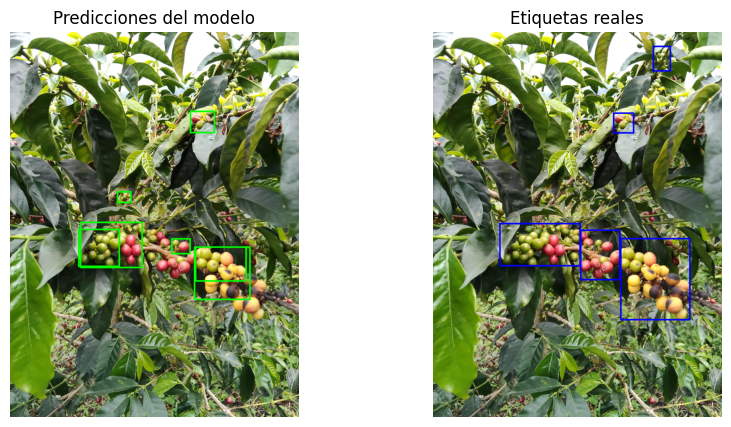


image 1/1 /content/data/labeled/clusters/YOLODataset/images/test/IMG20250402163646.jpeg: 640x480 32 clusters, 2256.0ms
Speed: 4.0ms preprocess, 2256.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


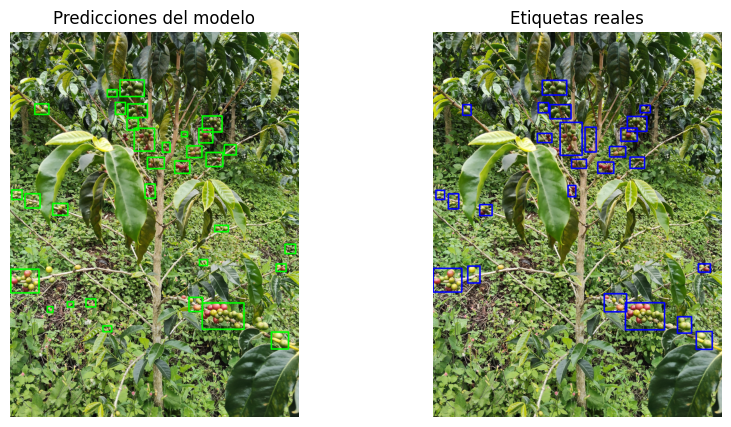

In [63]:
import os
import cv2
import matplotlib.pyplot as plt

test_img_folder = f"{DATA_PATH}/labeled/clusters/YOLODataset/images/test"
test_label_folder = f"{DATA_PATH}/labeled/clusters/YOLODataset/labels/test"

def read_labels(label_path):
    labels = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            labels.append(line.strip().split()[1:])
    return labels

def draw_boxes(image, labels, color):
    h, w, _ = image.shape
    for label in labels:
        x, y, width, height = map(float, label)
        x, y, width, height = int(x * w), int(y * h), int(width * w), int(height * h)
        cv2.rectangle(image, (x-width//2, y-height//2), (x + width//2, y + height//2), color, 15)
    return image

for img_name in os.listdir(test_img_folder):
    img_path = os.path.join(test_img_folder, img_name)
    label_path = os.path.join(test_label_folder, img_name.replace(".jpeg", ".txt"))

    img = cv2.imread(img_path)

    results = clusters_best.predict(source=img_path, conf=0.7)
    pred_labels = results[0].boxes.xywhn.tolist()
    real_labels = read_labels(label_path)

    img_pred = draw_boxes(img.copy(), pred_labels, (0, 255, 0))  # Verde para predicciones
    img_real = draw_boxes(img.copy(), real_labels, (255, 0, 0))  # Rojo para etiquetas reales

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Predicciones del modelo")
    axes[1].imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Etiquetas reales")

    for ax in axes:
        ax.axis("off")

    plt.show()

A pesar de que las métricas del modelo no son excelentes, sus resultados en la práctica si lo son, podemos ver que **casi nunca deja granos sin detectar**. Aún asi, comete errores al detectar dos veces el mismo cluster en dos o más cajas que solapan, pero esto tiene solución fácil, si dos cajas solapan, se reemplazan por una sola caja, la mas pequeña que las contenga a las dos.

A continuación se va a realizar ese procedimiento y guardar las nuevas cajas como imagenes separadas en `data/clusters`.

In [69]:
import glob
import numpy as np
import torchvision.ops as ops
import torch

raw_image_dir = f'{DATA_PATH}/raw'
clustered_output_dir = f'{DATA_PATH}/clusters'
os.makedirs(clustered_output_dir, exist_ok=True)

confidence_threshold = 0.7
iou_threshold = 0.3 # Intersection over Union (IoU) threshold para combinar cajas

image_files = glob.glob(os.path.join(raw_image_dir, '*.jpg'))
for image_path in image_files:
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        continue

    results = clusters_best.predict(source=image_path, conf=confidence_threshold)

    if results and len(results) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confidences = results[0].boxes.conf.cpu().numpy()
    else:
        boxes = np.array([])
        confidences = np.array([])
        print(f"No detections found for {image_path}")

    if boxes.size == 0:
        continue

    # Convertir a tensor para calcular IoU
    boxes_tensor = torch.tensor(boxes, dtype=torch.float)

    merged_box_indices = []
    remaining_indices = set(range(len(boxes_tensor)))

    while remaining_indices:
        current_index = min(remaining_indices)
        current_box = boxes_tensor[current_index].unsqueeze(0)

        # Calcula las cajas que intersectan
        iou_values = ops.box_iou(current_box, boxes_tensor[list(remaining_indices)])
        intersecting_indices_relative = (iou_values > iou_threshold).nonzero(as_tuple=True)[1].tolist()

        intersecting_indices_original = [list(remaining_indices)[i] for i in intersecting_indices_relative]
        merged_box_indices.append(intersecting_indices_original)

        for idx in intersecting_indices_original:
            remaining_indices.discard(idx)

    # Encuentra la caja mas pequeña que las contenga
    merged_boxes = []
    for group_indices in merged_box_indices:
        if not group_indices:
            continue
        group_boxes = boxes_tensor[group_indices]
        min_x = torch.min(group_boxes[:, 0])
        min_y = torch.min(group_boxes[:, 1])
        max_x = torch.max(group_boxes[:, 2])
        max_y = torch.max(group_boxes[:, 3])
        merged_boxes.append([min_x.item(), min_y.item(), max_x.item(), max_y.item()])

    merged_boxes = np.array(merged_boxes).astype(int)

    # Guarda cada caja como imagen separada
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    for i, box in enumerate(merged_boxes):
        x1, y1, x2, y2 = box
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)

        cropped_image = image[y1:y2, x1:x2]

        output_filename = f"{image_name}_cluster_{i}.png"
        output_path = os.path.join(clustered_output_dir, output_filename)

        cv2.imwrite(output_path, cropped_image)

print("Processing complete. Clustered images saved to", clustered_output_dir)


image 1/1 /content/data/raw/IMG20250402162809.jpg: 640x480 38 clusters, 2264.1ms
Speed: 4.3ms preprocess, 2264.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/raw/IMG20250402163829.jpg: 640x480 37 clusters, 4331.8ms
Speed: 5.6ms preprocess, 4331.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/raw/IMG20250402162223.jpg: 640x480 9 clusters, 2235.0ms
Speed: 4.1ms preprocess, 2235.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/raw/IMG20250402163535.jpg: 640x480 6 clusters, 2215.0ms
Speed: 4.0ms preprocess, 2215.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/raw/IMG20250402163433.jpg: 640x480 4 clusters, 2241.8ms
Speed: 4.3ms preprocess, 2241.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/raw/IMG20250402162233.jpg: 640x480 50 clusters, 2847.0ms
Speed: 4.2ms pre

### 2. Detección Granos